In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-15 13:14:19.581460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# TODO: put data in a data folder
df_olr = xr.open_dataset('olr_data.nc') 
df_pph = xr.open_dataset('pph_data.nc')
df_wg = xr.open_dataset('wind_geopot_data.nc')

### Taking out 1982/83 season

In [3]:
#take out 1982-5 -> 1983-5
cut_time_slice1 = slice('1979', '1982-5')
cut_time_slice2 = slice('1983-11', '2019')

df_olr = xr.merge([df_olr.sel(time=cut_time_slice1), df_olr.sel(time=cut_time_slice2)])
df_pph = xr.merge([df_pph.sel(time=cut_time_slice1), df_pph.sel(time=cut_time_slice2)])
df_wg = xr.merge([df_wg.sel(time=cut_time_slice1), df_wg.sel(time=cut_time_slice2)])


### Picking out the Anomolies for OLR Data

In [4]:
#calculate olr anomolies

#take the 21-day running means (for olr by mean)
olr_short = df_olr.olr.values
olr_byyear = np.reshape(olr_short, (212, 39, 13, 144))

season_meanolr = np.zeros((212, 13, 144))

for i in range(1,212):
    season_meanolr[i, :,:] = np.mean(np.squeeze(olr_byyear[i,:,:,:]))

season_meanolr

olr_day = np.roll(season_meanolr, (21,1))


olr_season = np.zeros((212, 39, 13, 144))

#subtract out the 21-day running mean to get anomalies
for i in range(1,39):
    for j in range(1,212):
        olr_season[j, i, :, :] = np.squeeze(olr_byyear[j,i,:,:]) - np.squeeze(olr_day[j,:,:])
olr_season


#take 5-day running mean to smooth out the data
olr = olr_season
olr = np.zeros((212, 39, 13, 144))

for i in range(1,39):
    olr[:, i, :, :] = np.roll(np.squeeze(olr_season[:, i, :, :]), (5,1))


df_olr.olr.values = np.reshape(olr, (8268, 13, 144))

### Post-Normalized Graphs of the Data

(array([3.044800e+04, 6.873220e+05, 2.621158e+06, 6.909057e+06,
        5.222788e+06, 6.087000e+03, 0.000000e+00, 1.800000e+01,
        1.140000e+02, 7.040000e+02]),
 array([-4.85600848, -3.48210102, -2.10819357, -0.73428612,  0.63962133,
         2.01352878,  3.38743623,  4.76134368,  6.13525114,  7.50915859,
         8.88306604]),
 <BarContainer object of 10 artists>)

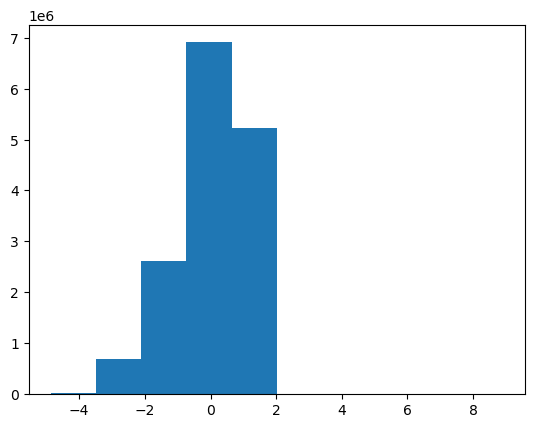

In [6]:
plt.hist(list(np.reshape(df_olr.olr.values, (15477696, 1))[:, 0]))

(array([9.3200000e+02, 2.9891000e+04, 5.2861200e+05, 6.2866100e+06,
        3.6799447e+07, 4.6042187e+07, 1.0840932e+07, 1.0454670e+06,
        4.6925000e+04, 9.8500000e+02]),
 array([-6.68076329, -5.37567764, -4.07059199, -2.76550634, -1.46042068,
        -0.15533503,  1.14975062,  2.45483628,  3.75992193,  5.06500758,
         6.37009323]),
 <BarContainer object of 10 artists>)

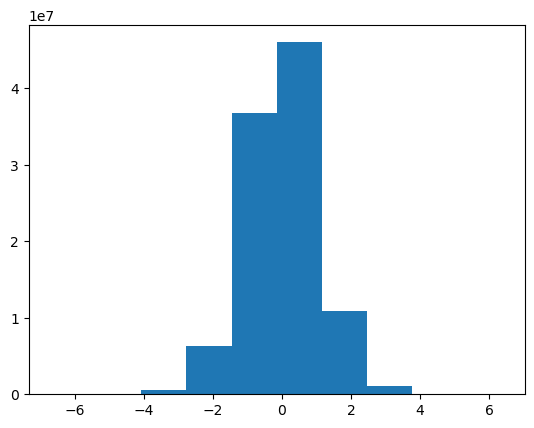

In [13]:
plt.hist(list(np.reshape(df_wg.u250.values, (101621988, 1))[:, 0]))

### Normalizing the Data

In [5]:
#normalizing z500 data
z500_means = np.mean(df_wg.z500.values)
z500_std = np.std(df_wg.z500.values)
df_wg.z500.values = (df_wg.z500.values - z500_means)/z500_std

#normalizing u250 data
u250_means = np.mean(df_wg.u250.values)
u250_std = np.std(df_wg.u250.values)
df_wg.u250.values = (df_wg.u250.values - u250_means)/u250_std

#normalizing olr data
olr_means = np.mean(df_olr.olr.values)
olr_std = np.std(df_olr.olr.values)
df_olr.olr.values = (df_olr.olr.values - olr_means)/olr_std


In [17]:
#creating a list of all the dates being used
label_list = list(np.datetime_as_string(df_olr.time.values))
for i, val in enumerate(label_list):
    label_list[i] = val.split('T')[0]

### Seperating PPH Data by Location and Type
This is where I made the daily means for pph values at each location. It took forever to run so I commented it out and downloaded it as a csv file called ('pph_loc_mean.csv'). 

In [ ]:
# locators

# finds the mean at specific dates and types of scs in the West
def west_locator(date, scs):
    d = df_pph.sel(time=date).lon.values  #gets lon values from date

    w = np.where((d < -105) & (d > -120)) # finds what lon values are in the west US


    l = 0
    # puts tor values in the west US into a array 
    for i in range(np.size(w[0])):
        l = l +df_pph.sel(time=date, x=w[0][i], y = w[1][i])[scs].values

    #returns sum of events
    return l/len(w[0]) 

# finds the mean at specific dates and types of scs in central US
def central_locator(date, scs):
    d = df_pph.sel(time=date).lon.values 
    a = df_pph.sel(time=date).lat.values 


    w_1 = np.where((d > -105) & (d < -94.6) & (a > 25) & (a < 36.5)) # west coordinates in d
    w_2 = np.where((d > -105) & (d < -80.5) & (a > 36.5) & (a < 49)) # west coordinates in d

    l=0
    for i in range(np.size(w_1[0])):
        l= l+df_pph.sel(time=date, x=w_1[0][i], y = w_1[1][i])[scs].values

    for i in range(np.size(w_2[0])):
        l=l+df_pph.sel(time=date, x=w_2[0][i], y = w_2[1][i])[scs].values

    return l/(len(w_1[0]) + len(w_2[0]))

# finds the mean at specific dates and types of scs in the East
def east_locater (date, scs):
    d = df_pph.sel(time=date).lon.values 
    a = df_pph.sel(time=date).lat.values 

    w_1 = np.where((d > -83) & (d < -79.8) & (a > 25) & (a < 29)) 
    w_2 = np.where((d > 94.6) & (d < -85) & (a > 29) & (a < 36.5)) 
    w_3 = np.where((d > 80.5) & (d < -66) & (a > 36.5) & (a < 49)) 

    
    l=0
    for i in range(np.size(w_1[0])):
        l= l+df_pph.sel(time=date, x=w_1[0][i], y = w_1[1][i])[scs].values

    for i in range(np.size(w_2[0])):
        l=l+df_pph.sel(time=date, x=w_2[0][i], y = w_2[1][i])[scs].values

    for i in range(np.size(w_3[0])):
        l=l+df_pph.sel(time=date, x=w_3[0][i], y = w_3[1][i])[scs].values

    return l/(len(w_1[0]) + len(w_2[0]) + len(w_3[0]))


In [ ]:

'''
west_tor = dict()
west_wind = dict()
west_hail = dict()

central_tor = dict()
central_wind = dict()
central_hail = dict()

east_tor = dict()
east_wind = dict()
east_hail = dict()

for date in label_list:
    west_tor[date] = west_locator(date, 'tor')
    west_wind[date] = west_locator(date, 'wind')
    west_hail[date] = west_locator(date, 'hail')

    central_tor[date] = central_locator(date, 'tor')
    central_wind[date] = central_locator(date, 'wind')
    central_hail[date] = central_locator(date, 'hail')

    east_tor[date] = east_locater(date, 'tor')
    east_wind[date] = east_locater(date, 'wind')
    east_hail[date] = east_locater(date, 'hail')

here = pd.DataFrame.from_dict(west_tor, orient='index').rename(columns={0: 'west_tor'})
here['west_wind'] = list(west_wind.values())
here['west_hail'] = list(west_hail.values())

here['central_tor'] = list(central_tor.values())
here['central_wind'] = list(central_wind.values())
here['central_hail'] = list(central_hail.values())

here['east_tor'] = list(east_tor.values())
here['east_wind'] = list(east_wind.values())
here['east_hail'] = list(east_hail.values())

here.to_csv('./pph_loc_mean.csv')

'''

In [15]:
pph_data = pd.read_csv('pph_loc_mean.csv').rename(columns={'Unnamed: 0': 'date'}).set_index('date')
pph_data

,west_tor,west_wind,west_hail,central_tor,central_wind,central_hail,east_tor,east_wind,east_hail
date,,,,,,,,,
1979-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1979-11-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1979-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1979-11-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1979-11-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2019-05-27,0.200550,0.038387,0.274401,3.712219,4.844967,5.126097,0.0,0.000000,0.000000
2019-05-28,0.012979,0.002045,0.064389,1.073510,3.527014,5.957370,0.0,0.587768,0.000000
2019-05-29,0.000000,0.000008,0.000890,2.231628,5.683658,2.266128,0.0,0.000000,0.000000


### Formatting data to output time-series-like

In [18]:
#creating windows and horizons
HORIZON = 7 # PPH from 7 days afterwords
WINDOW = 30 # assumes sliding in days


# creates a expanding window from given label -- WORKS!
def get_window_expanding(label="", label_list=label_list):
    try:
        # take the season
        # season_index = label_list.index(label)

        # grab all the days previous to one that you have
        window = [0]*(len(label_list)-7)
        for i in range(len(window)):
            window[i] = label_list[len(label_list)-i-8]
        # return window and label
        return window, label
        
    
    #printing error when value is not in seasons list
    except:
        return "Label not found in list"
    

# creates a sliding window from given label -- WORKS!
def get_window_sliding (label="", window_num=WINDOW):
    try: 
        #ensure not grabbing from diff season
        day_index = label_list.index(label)
        m = int(label.split('-')[1])
        d = int(label.split('-')[2])

        #for values that are almost outside the season, use and expanding window 
        if (m ==11 ) or (m ==12 and d < 7):
            y = label.split('-')[0]
            stopper = y+'-11-01' #end of the season
            stop_index = label_list.index(stopper)

            #creates a new list to grab data from
            label_list_copy = label_list.copy()[stop_index:day_index+1]

            return (get_window_expanding(label=label, label_list=label_list_copy))

        else:
            window = [0]*(window_num)

            for i in range(len(window)):
                window[i] = label_list[day_index-i-7] #TODO: 7 days between or pph_day - last_day = 7
            return window, label  
    
    except:
        return "Label not found in list"
    

# returns wind and geopotential dataframe for prev 30 days (minus 7d), olr dataframe for prev 30 days(minus 7d), 
# and pph data for the given date
def get_data(date):
    dates = get_window_sliding(date)
    past_dates = dates[0]
    target_data = pph_data.loc[date]
    slicer = slice(past_dates[-1], past_dates[0])

    return df_wg.sel(time=slicer), df_olr.sel(time=slicer), target_data

In [21]:

get_data('1990-05-11')[2]

west_tor        0.000387
west_wind       0.003701
west_hail       0.000692
central_tor     0.411127
central_wind    1.326020
central_hail    2.038079
east_tor        0.000000
east_wind       0.000000
east_hail       0.000000
Name: 1990-05-11, dtype: float64

### Spliting the Data into Train, Test, and Validation sets

In [ ]:
#training data
train_slice = slice('1983-11', '2016-5') # TODO: not sure if it's supposed to be -> 2013 || 2016
train_olr = df_olr.sel(time=train_slice)
train_pph = df_pph.sel(time=train_slice)
train_wg = df_wg.sel(time=train_slice)

#testing data
test_slice = slice('2016-11', '2019')
test_olr = df_olr.sel(time=test_slice)
test_pph = df_pph.sel(time=test_slice)
test_wg = df_wg.sel(time=test_slice)

#validation data - because this stuff will be more variable then our testing data (tech to measure is not as good)
validation_slice = slice('1979', '1982-5')
val_olr = df_olr.sel(time=validation_slice)
val_pph = df_pph.sel(time=validation_slice)
val_wg = df_wg.sel(time=validation_slice)

### Model Building

Input(shape=(#steps,#features))

In [ ]:
# creates a conv2d and max pool sequence 
# rounds: how many conv2d-max pool sequences wanted
# n_c2d_filters: filters
# num filters/rounds = how many conv2d layers will be in each round/sequence

def conv_2d_max_pool_seq (input_x, rounds, n_c2d_filters, activation, kernel_size=3):
  if len(n_c2d_filters)%rounds != 0:
    return "Incorrect number of filters"
  else:
    i = 0
    x = input_x
    d = int(len(n_c2d_filters)/rounds)
    while i < rounds:
      for n in range(d):
        x = layers.Conv2D(filters=n_c2d_filters[int(n+d*i)], kernel_size= kernel_size, activation=activation, padding='same')(x)
      print(d)
      x = layers.MaxPooling2D((2,2))(x)
      i = i+1
    x = layers.Flatten()(x)
    return(x)
  



In [ ]:
#TODO: make her better for hyperparameter tuning

input_wg = keras.Input(shape=(51, 214, 3), name="wind-geopot input")
input_olr = keras.Input(shape=(13, 144, 3), name="olr input")

#dense output = 3 -> east, central, west 

#This model puts everything together; TODO: re-order parameters
def model_maker(input_wg, input_olr, rounds, n_c2d_filters, hidden_nodes, 
                dropout_rate, activation, name, kernel_reg, kernel_size=3):
    
    
    x = layers.concatenate([conv_2d_max_pool_seq(input_wg, rounds, n_c2d_filters, activation, kernel_size), 
                            conv_2d_max_pool_seq(input_olr, rounds, n_c2d_filters, activation, kernel_size)])
    
    #need to also concatenate 

    for h in hidden_nodes:
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(h, activation=activation)(x)



    outputs = layers.Dense(9, kernel_regularizer=kernel_reg)(x) #ridge regression for regulizer

    model = keras.Model(
        inputs = [input_wg, input_olr], 
        outputs = outputs, 
        name=name)
    return model



In [ ]:
model = model_maker()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True,
                                                      min_delta=0.01)

model.fit(x=[], y=[], epochs=20, verbose=1,
                        validation_data=([], []), 
                        callbacks=[])